In [2]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import csv
from dateutil import parser
import re

import sys
import math
import igraph
from numpy.linalg import lstsq
from numpy import dot
from scipy.cluster.vq import kmeans2, vq
from scipy.linalg import norm
from scipy.optimize import minimize
from sklearn.decomposition import NMF
from collections import defaultdict

In [3]:
def replace_list_to_string(string):
    replacable_items = ['[', ']']
    for item in replacable_items:
        string = string.replace(item, '')
    return string

def convert_to_alpha_only(string):
    '''
    returns only alphabets and spaces from a string
    '''
    valids = re.sub(r"[^\sA-Za-z]+", '', string)
    return valids

## Creating the network

In [4]:
with open('./ignored_datasets/dhaka_tribune_statement_network.csv', 'r') as f:
    reader = csv.reader(f, delimiter=",")
    reader.next()
    count = 0
    news_net = nx.Graph()
    for splitted_line in reader:
        count += 1
        time = parser.parse(splitted_line[1])
        #print 'time', time
        entity_1 = convert_to_alpha_only(splitted_line[2].lower())
        #print entity_1
        entity_1_type = splitted_line[3]
        #print entity_1_type
        entity_2 = convert_to_alpha_only(splitted_line[4].lower())
        #print entity_2
        entity_2_type = splitted_line[5]
        #print entity_2_type
        sentence = splitted_line[6]
        #print sentence
        original_tag = eval(replace_list_to_string(splitted_line[7]))
        #print original_tag
        naive_tag = eval(replace_list_to_string(splitted_line[8]))
        #print naive_tag
        keywords = eval(splitted_line[9])
        #print keywords

        ## create an undirected network between two actor in statement network
        network_mix = ['PERSON']
        if entity_1_type in network_mix and entity_2_type in network_mix:
            news_net.add_edge(entity_1, entity_2)
        
        if count % 50000 == 0:
            print 'count', count

count 50000
count 100000
count 150000
count 200000
count 250000


In [5]:
news_net.number_of_nodes()

11032

In [57]:
def get_binned_distribution(values, number_of_bins = 20, log_binning = False, base = 10):
    lower_bound = min(values)
    upper_bound = max(values)
    
    if log_binning:
        lower_bound = np.log10(lower_bound)/ np.log10(base) if lower_bound > 0 else -1
        upper_bound = np.log10(upper_bound)/ np.log10(base)
        bins = np.logspace(lower_bound, upper_bound, number_of_bins, base=base)
    else:
        bins = np.linspace(lower_bound, upper_bound, number_of_bins)
    
    ## Calculating histogram
    y, _ = np.histogram(values, bins = bins, density = True)
    
    ## Now for each y we need to compute the value of x
    x = bins[1:] - np.diff(bins) / 2.
    
    # sanity check for probability density
    #print sum(map(lambda a,b : a*b, [bins[i] - bins[i-1] for i in xrange(1,len(bins))],y))
    
    return x,y

In [58]:
 def plot(x,y, log = True, xsize = 8, ysize = 3, xlabel="", ylabel=""):
    plotted_figure = plt.figure(figsize = (xsize,ysize))
    if log:
        plt.loglog(x,y, '.')
    else:
        plt.plot(x,y, '.')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return plotted_figure

In [60]:
G = news_net

## Density of the network

In [62]:
N = G.number_of_nodes()
print N
E = G.number_of_edges()
print E

11032
22898


In [63]:
D = E/(N*(N-1)/2.)
print D

0.000376320960857


## Degree Distribution

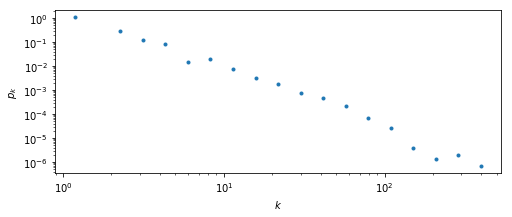

In [64]:
x,y = get_binned_distribution(G.degree().values(), log_binning=True)
_ = plot(x,y, xlabel=r"$k$", ylabel=r"$p_{k}$")

In [65]:
if nx.is_connected(G):
    print "The network is connected"
else:
    print "The network is not connected"

The network is not connected


## Exploring Pagerank

In [67]:
pr_G = nx.pagerank(G)
sorted(pr_G.items(),key = lambda x:x[1], reverse= True)[:20]

[('sheikh hasina', 0.006856654666469954),
 ('khaleda zia', 0.004882158751215923),
 ('khaleda', 0.004157961698432365),
 ('hasina', 0.0037332890281961822),
 ('ershad', 0.002759687243959488),
 ('rab', 0.0022560853199691663),
 ('hossain', 0.002025513878755672),
 ('rahman', 0.0019985986890039696),
 ('monirul', 0.0019414131675543592),
 ('nizami', 0.001826097869262556),
 ('khokon', 0.0016807791315876768),
 ('babul', 0.001663506740730791),
 ('nur hossain', 0.0015478675129495638),
 ('zia', 0.0015396825649786512),
 ('fakhrul', 0.0014061678906236205),
 ('mizanur rahman', 0.0014023316306390774),
 ('kamal', 0.0013839428036941828),
 ('tarique rahman', 0.0013565837203735017),
 ('jahangir', 0.001269114171609387),
 ('shamim', 0.0012603502334476776)]

In [ ]:
bn_without_weight = nx.betweenness_centrality(G)
sorted(bn_without_weight.items(),key = itemgetter(1), reverse= True)[:20]

## Exploring K-Coreness

In [70]:
G.remove_edges_from(G.selfloop_edges())

In [73]:
sorted(nx.core_number(G).items(), key= lambda x:x[1], reverse=True)[:100]

[('khaleda zia', 12),
 ('mirza fakhrul islam alamgir', 12),
 ('bangabandhu sheikh mujibur rahman', 12),
 ('ziaur rahman', 12),
 ('hanif', 12),
 ('zia', 12),
 ('rahman', 12),
 ('sheikh mujibur rahman', 12),
 ('tarique rahman', 12),
 ('fakhrul', 12),
 ('hasina', 12),
 ('mujib', 12),
 ('tarique', 12),
 ('bangabandhu', 12),
 ('sheikh hasina', 12),
 ('khaleda', 12),
 ('sheikh mujib', 12),
 ('osman', 11),
 ('nazrul islam', 11),
 ('moudud', 11),
 ('suranjit sengupta', 11),
 ('hossain', 11),
 ('suranjit', 11),
 ('akram', 11),
 ('nur hossain', 11),
 ('latif siddique', 11),
 ('mahbubulalam hanif', 11),
 ('mahbubul alam hanif', 11),
 ('mohammad nasim', 11),
 ('siddique', 11),
 ('rizvi', 11),
 ('koko', 11),
 ('shahidul', 11),
 ('shamim osman', 11),
 ('nazrul', 11),
 ('nasim', 11),
 ('nur', 11),
 ('ruhul kabir rizvi', 11),
 ('shamim', 11),
 ('abdul hamid', 11),
 ('hasan mahmud', 11),
 ('joy', 11),
 ('begum khaleda zia', 11),
 ('latif', 11),
 ('mirza fakhrul', 11),
 ('kamal', 11),
 ('ershad', 11),
 